# Experiments to improve classification accuracy

In [1]:
from IPython.display import display
import pandas as pd
import pylab
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

pylab.rcParams['figure.figsize'] = (10, 5)

## First, let's look at the baseline results

In [2]:
LANGUAGE_CODE_TO_NAME = {
    'af': 'Afrikaans',
    'ar': 'Arabic',
    'bg': 'Bulgarian',
    'bn': 'Bengali',
    'ca': 'Catalan',
    'cs': 'Czech',
    'da': 'Danish',
    'de': 'German',
    'el': 'Greek',
    'en': 'English',
    'es': 'Spanish',
    'et': 'Estonian',
    'fa': 'Persian',
    'fi': 'Finnish',
    'fr': 'French',
    'gu': 'Gujarati',
    'he': 'Hebrew',
    'hi': 'Hindi',
    'hr': 'Croatian',
    'hu': 'Hungarian',
    'id': 'Indonesian',
    'it': 'Italian',
    'ja': 'Japanese',
    'kn': 'Kannada',
    'ko': 'Korean',
    'lt': 'Lithuanian',
    'lv': 'Latvian',
    'mk': 'Macedonian',
    'ml': 'Malayalam',
    'mr': 'Marathi',
    'ne': 'Nepali',
    'nl': 'Dutch',
    'no': 'Norwegian',
    'pa': 'Punjabi',
    'pl': 'Polish',
    'pt': 'Portuguese',
    'ro': 'Romanian',
    'ru': 'Russian',
    'si': 'Sinhalese',
    'sk': 'Slovak',
    'sl': 'Slovene',
    'so': 'Somali',
    'sq': 'Albanian',
    'sv': 'Swedish',
    'sw': 'Swahili',
    'ta': 'Tamil',
    'te': 'Telugu',
    'th': 'Thai',
    'tl': 'Tagalog',
    'tr': 'Turkish',
    'uk': 'Ukrainian',
    'ur': 'Urdu',
    'vi': 'Vietnamese',
    'zh-cn': 'Simplified Chinese',
    'zh-tw': 'Traditional Chinese'
}

RESULT_PARAM_COLS = ['datasetName', 'substringLength', 'sampleSize', 'useShortProfile', 'useAllLanguages']

In [3]:
baseline_results = pd.read_csv('../src/test/resources/org/xbib/elasticsearch/index/mapper/langdetect/accuracies.csv')
baseline_results.T.head(10).T.head()

,datasetName,substringLength,sampleSize,useShortProfile,useAllLanguages,af,ar,bg,bn,ca
0,udhr,5,100,True,False,NaN,0.83,0.45,1,NaN
1,udhr,10,100,True,False,NaN,0.97,0.64,1,NaN
2,udhr,20,100,True,False,NaN,0.99,0.91,1,NaN
3,udhr,50,100,True,False,NaN,1,0.93,1,NaN
4,udhr,100,100,True,False,NaN,1,1,1,NaN


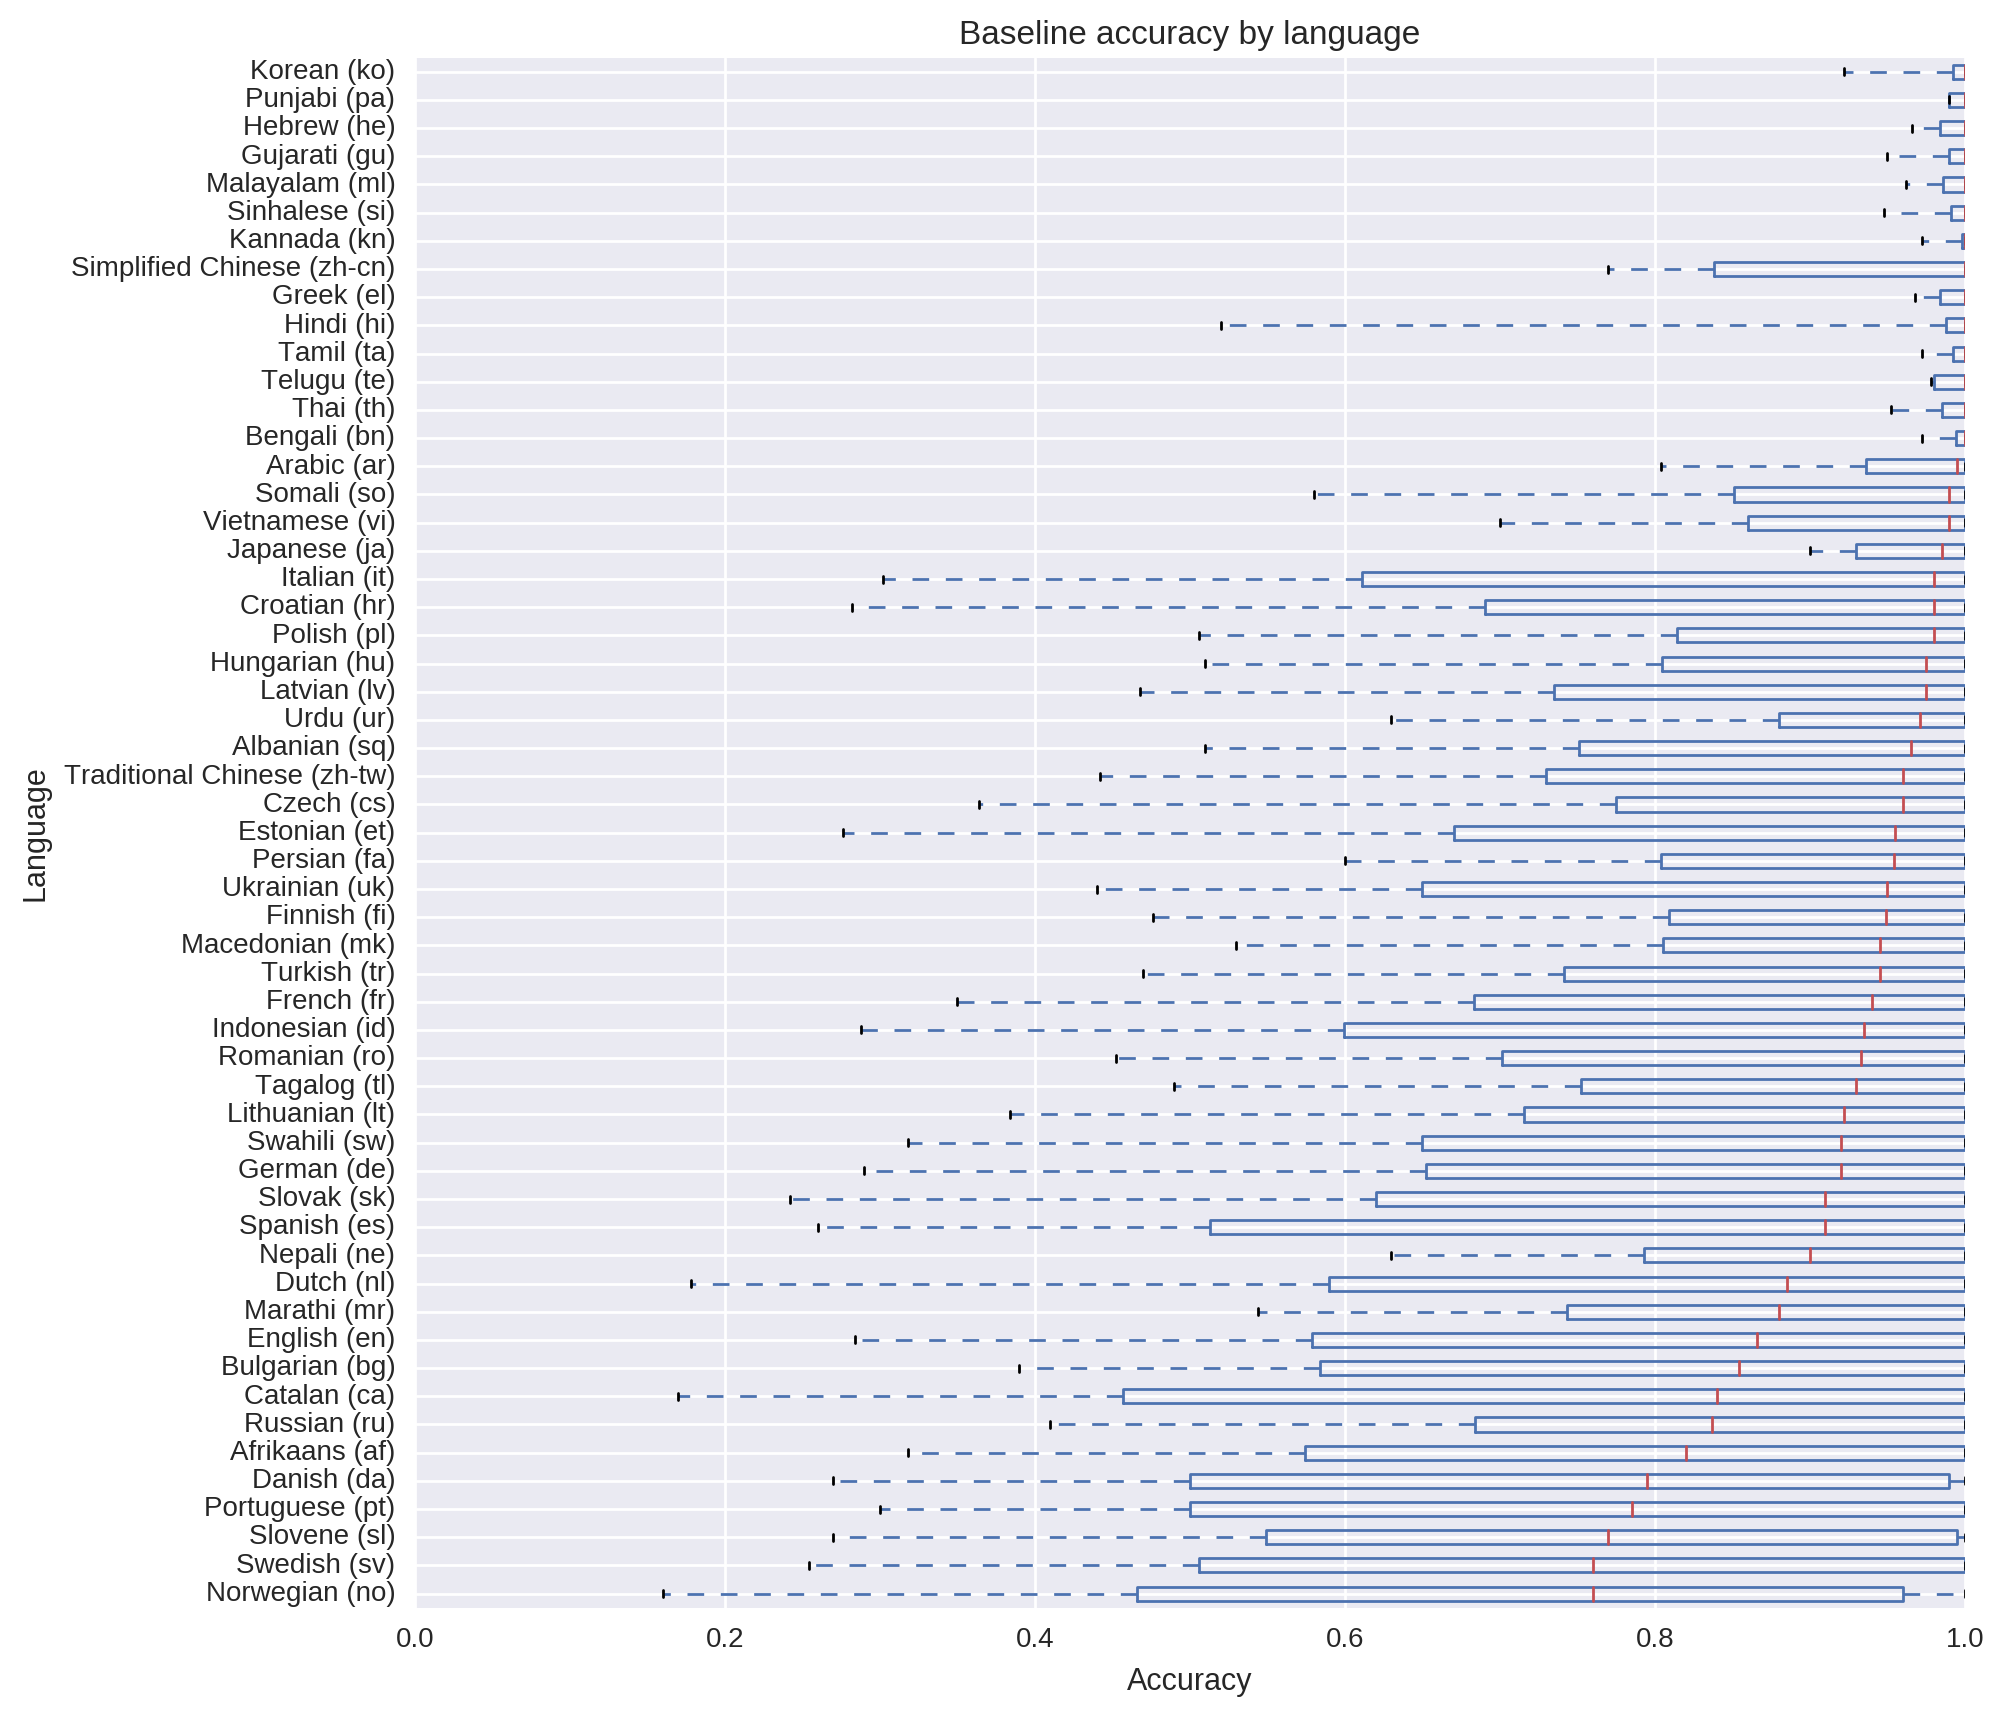

In [4]:
def extract_accuracies(results):
    accuracies = results.drop(RESULT_PARAM_COLS, axis=1)
    accuracies.rename_axis({k: '{} ({})'.format(v, k) for k, v in LANGUAGE_CODE_TO_NAME.items()},
                           axis=1, inplace=True)
    return accuracies

def plot_accuracy_by_language(results, name):
    accuracies = extract_accuracies(results)
    ax = accuracies[accuracies.median().sort_values().index].plot(
        kind='box', vert=False, figsize=(10, 10), whis='range'
    )
    ax.set_xlim((0.0, 1.0))
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Language')
    ax.set_title('{} accuracy by language'.format(name))

plot_accuracy_by_language(baseline_results, 'Baseline')

## Now, let's run a little experiment

In [5]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=no-ngram-subsampling \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/no-ngram-subsampling.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 49.878 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


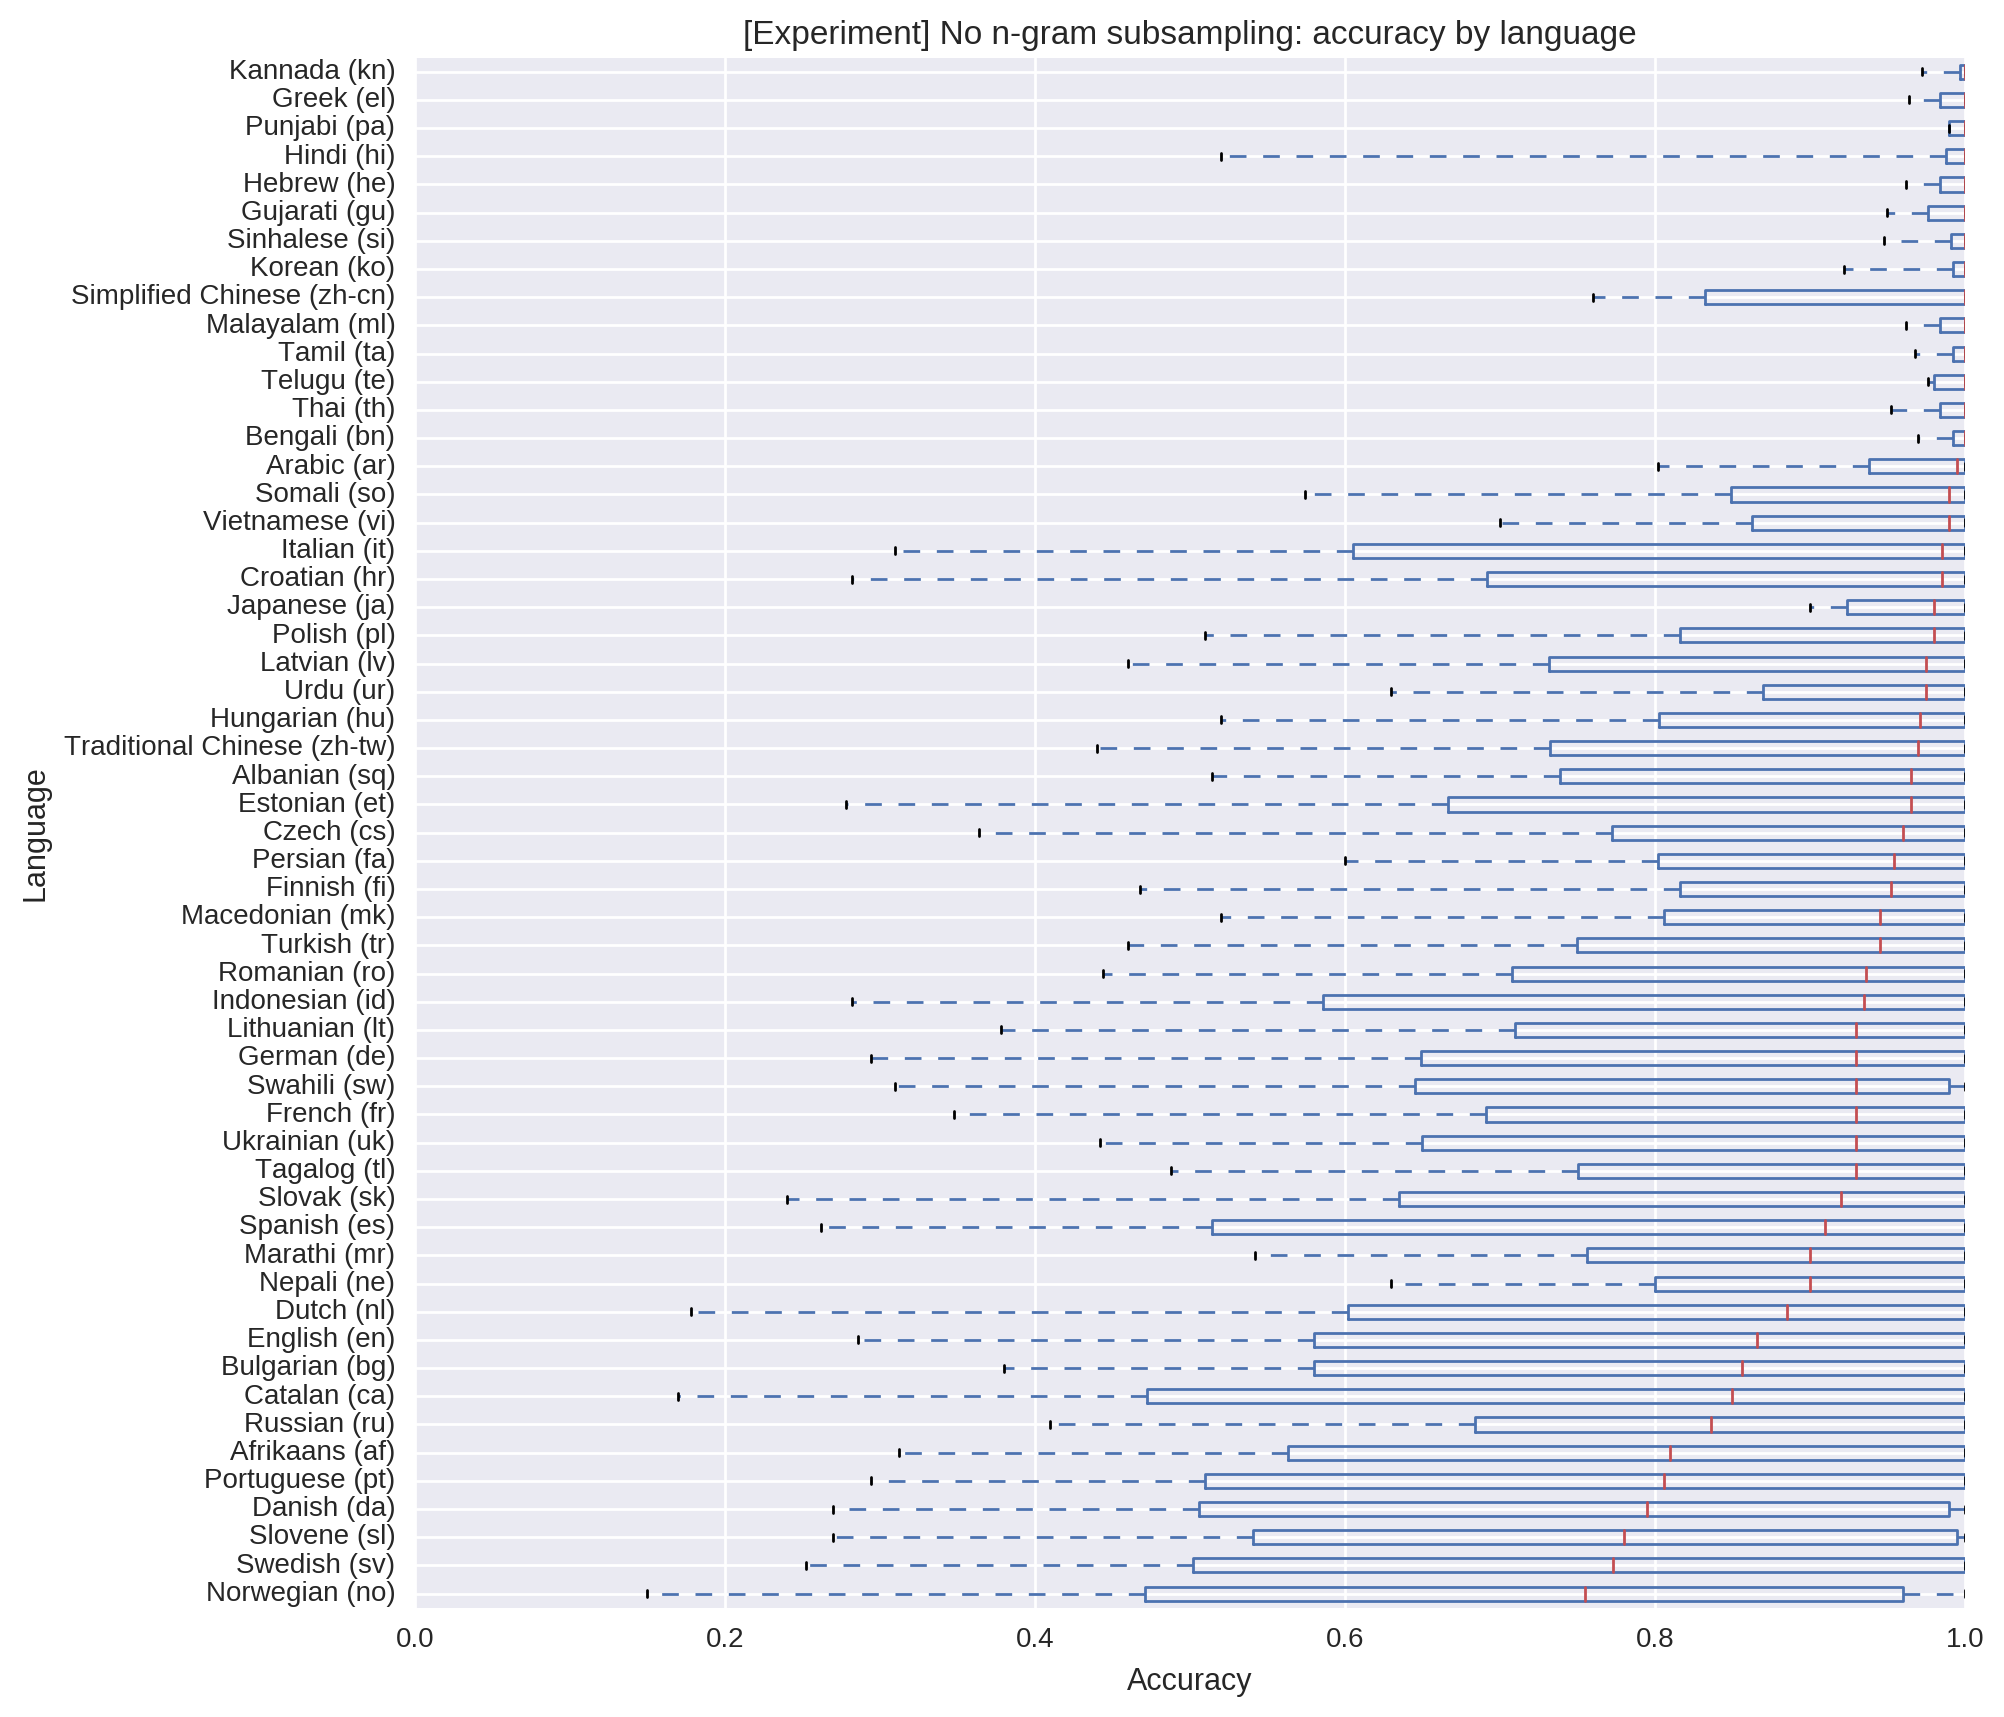

In [6]:
no_ngram_subsampling_results = pd.read_csv('results/no-ngram-subsampling.csv')
plot_accuracy_by_language(no_ngram_subsampling_results, '[Experiment] No n-gram subsampling:')

### Doesn't look that different &ndash; better look at the accuracy deltas to see how our experiment results compare to the baseline

Unfortunately, it doesn't like there's much of a difference... If anything, it is slightly negative. Better run other experiments!

Delta counts (positive is better than the baseline; total number of results: 2090)


,count,percent
negative,386,0.184689
positive,292,0.139713
zero,1412,0.675598


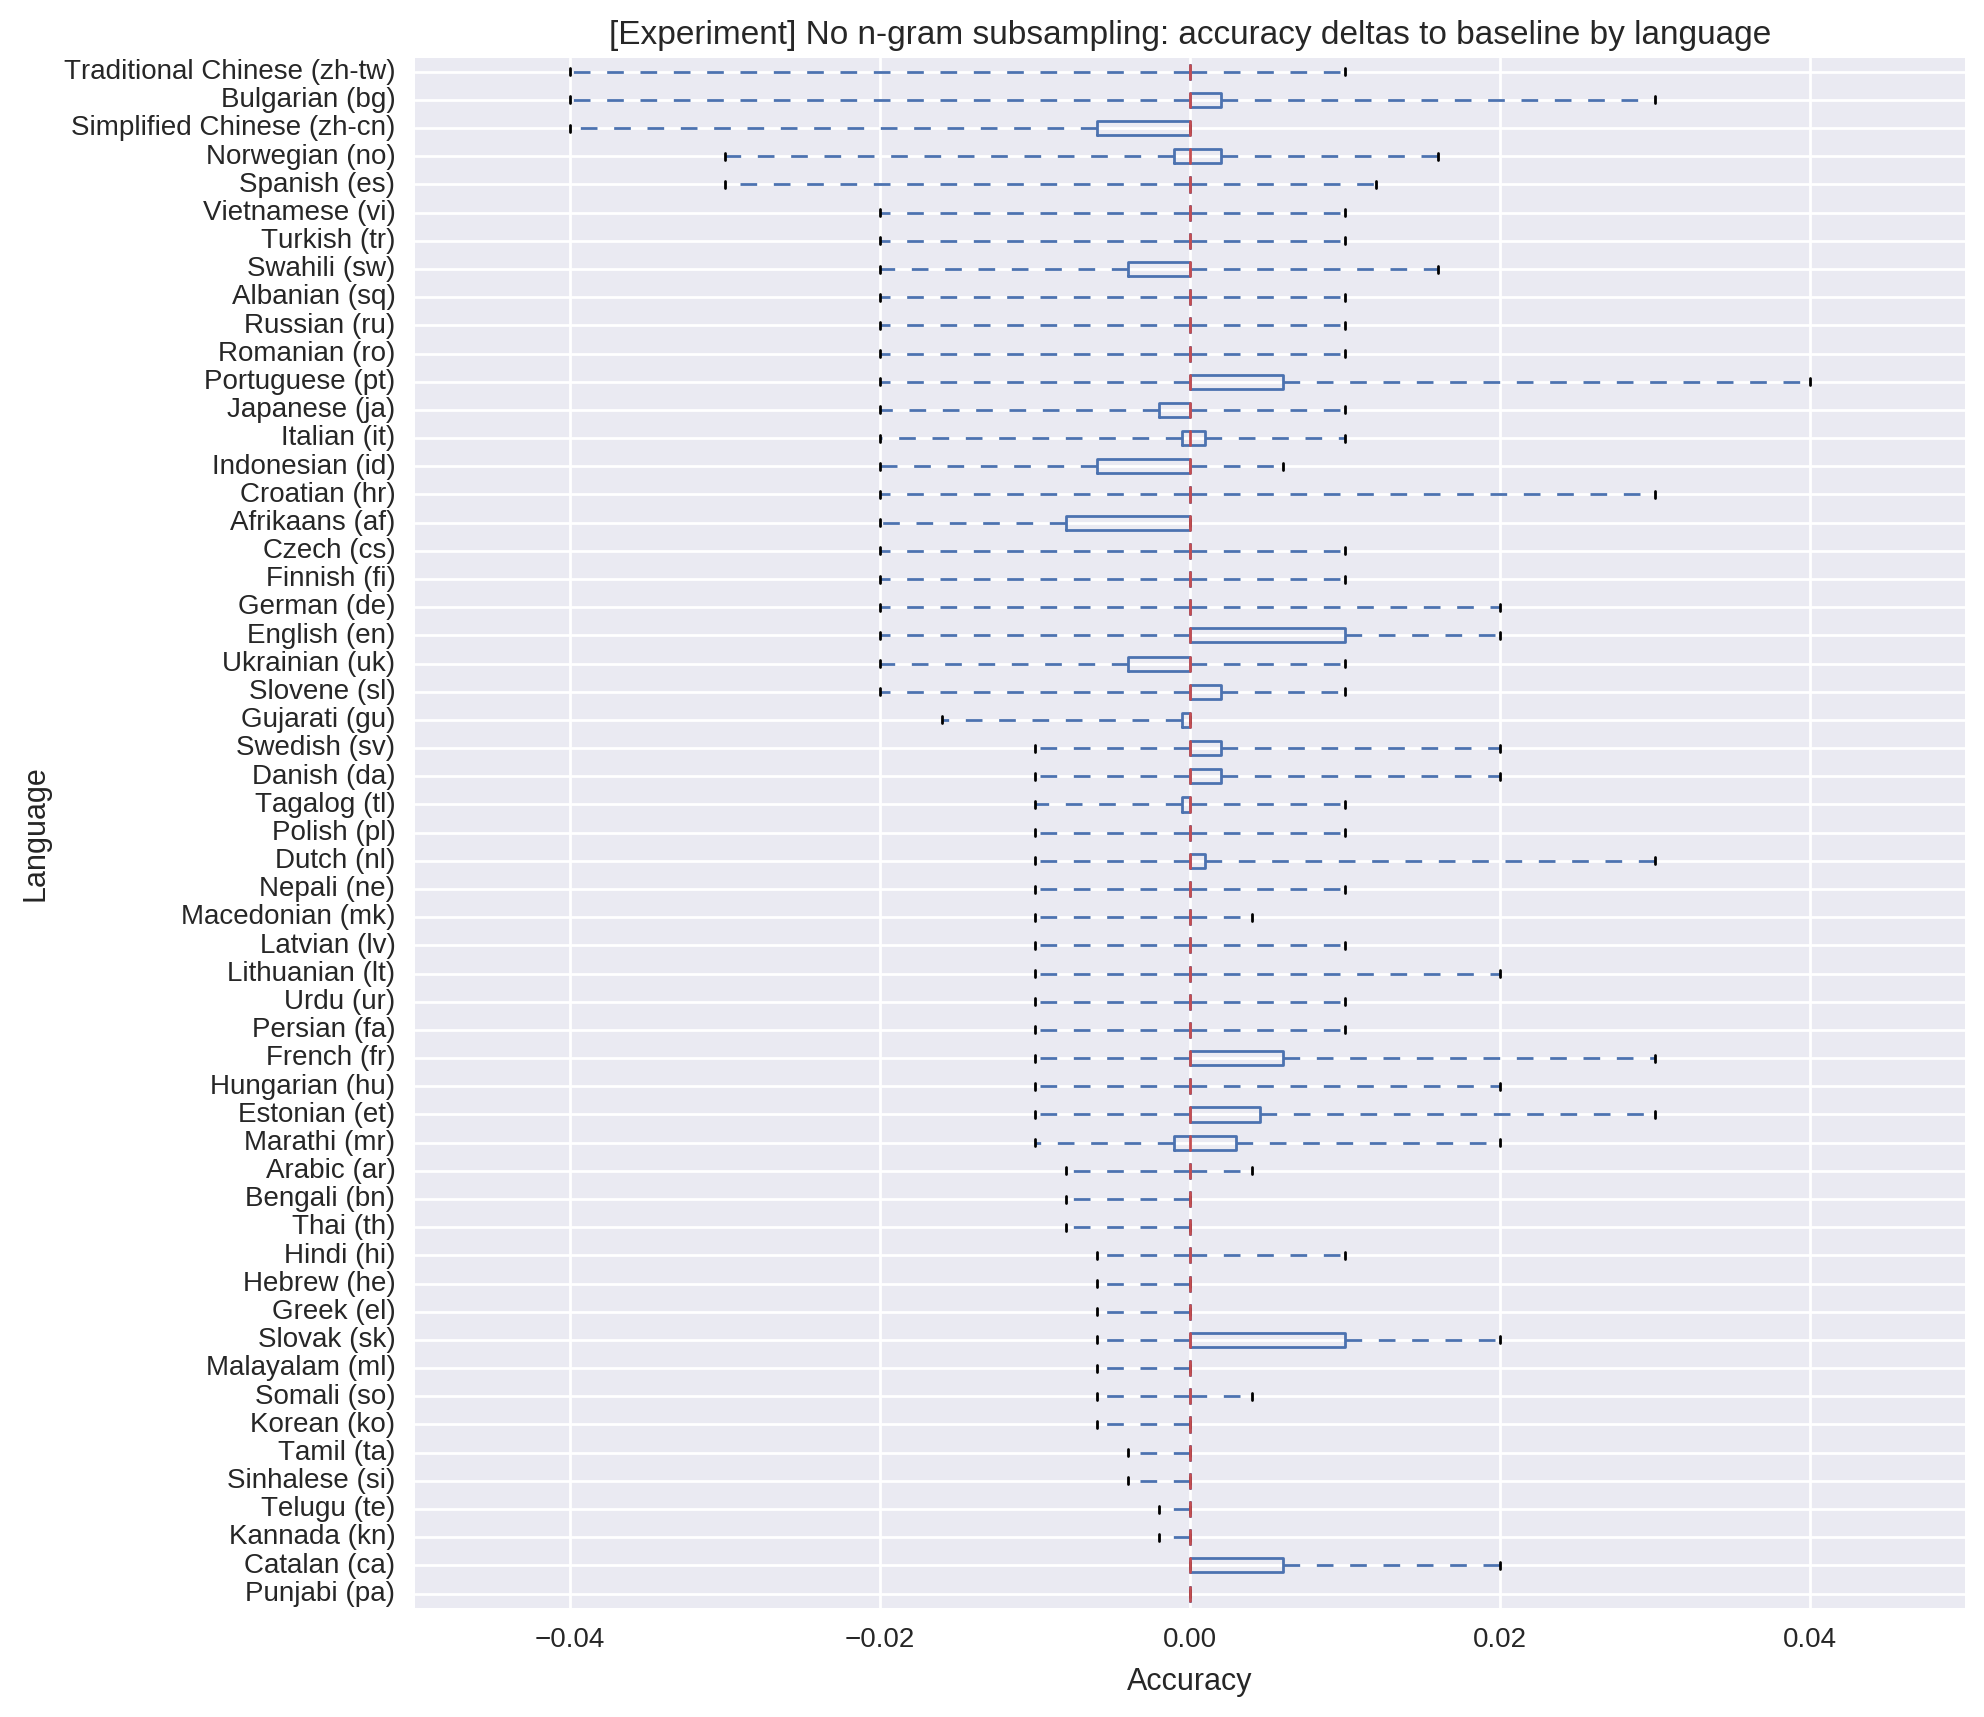

In [7]:
def plot_accuracy_deltas_by_language(baseline_results, experiment_results, experiment_name):
    baseline_accuracies = extract_accuracies(baseline_results)
    deltas = extract_accuracies(experiment_results) - baseline_accuracies
    delta_counts = pd.Series({k: v.sum().sum() for k, v in dict(positive=deltas > 0,
                                                                negative=deltas < 0,
                                                                zero=deltas == 0).items()})
    print('Delta counts (positive is better than the baseline; total number of results: {})'.format(delta_counts.sum()))
    display(pd.DataFrame(dict(count=delta_counts, percent=delta_counts / delta_counts.sum())))

    ax = deltas[deltas.min().sort_values(ascending=False).index].plot(
        kind='box', vert=False, figsize=(10, 10), whis='range'
    )
    positive_limit = deltas.abs().max().max() + 0.01
    # Keep the x-axis symmetrical
    ax.set_xlim((-positive_limit, positive_limit))
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Language')
    ax.set_title('{} accuracy deltas to baseline by language'.format(experiment_name))

plot_accuracy_deltas_by_language(baseline_results,
                                 no_ngram_subsampling_results,
                                 '[Experiment] No n-gram subsampling:')

Delta counts (positive is better than the baseline; total number of results: 1140)


,count,percent
negative,365,0.320175
positive,280,0.245614
zero,495,0.434211


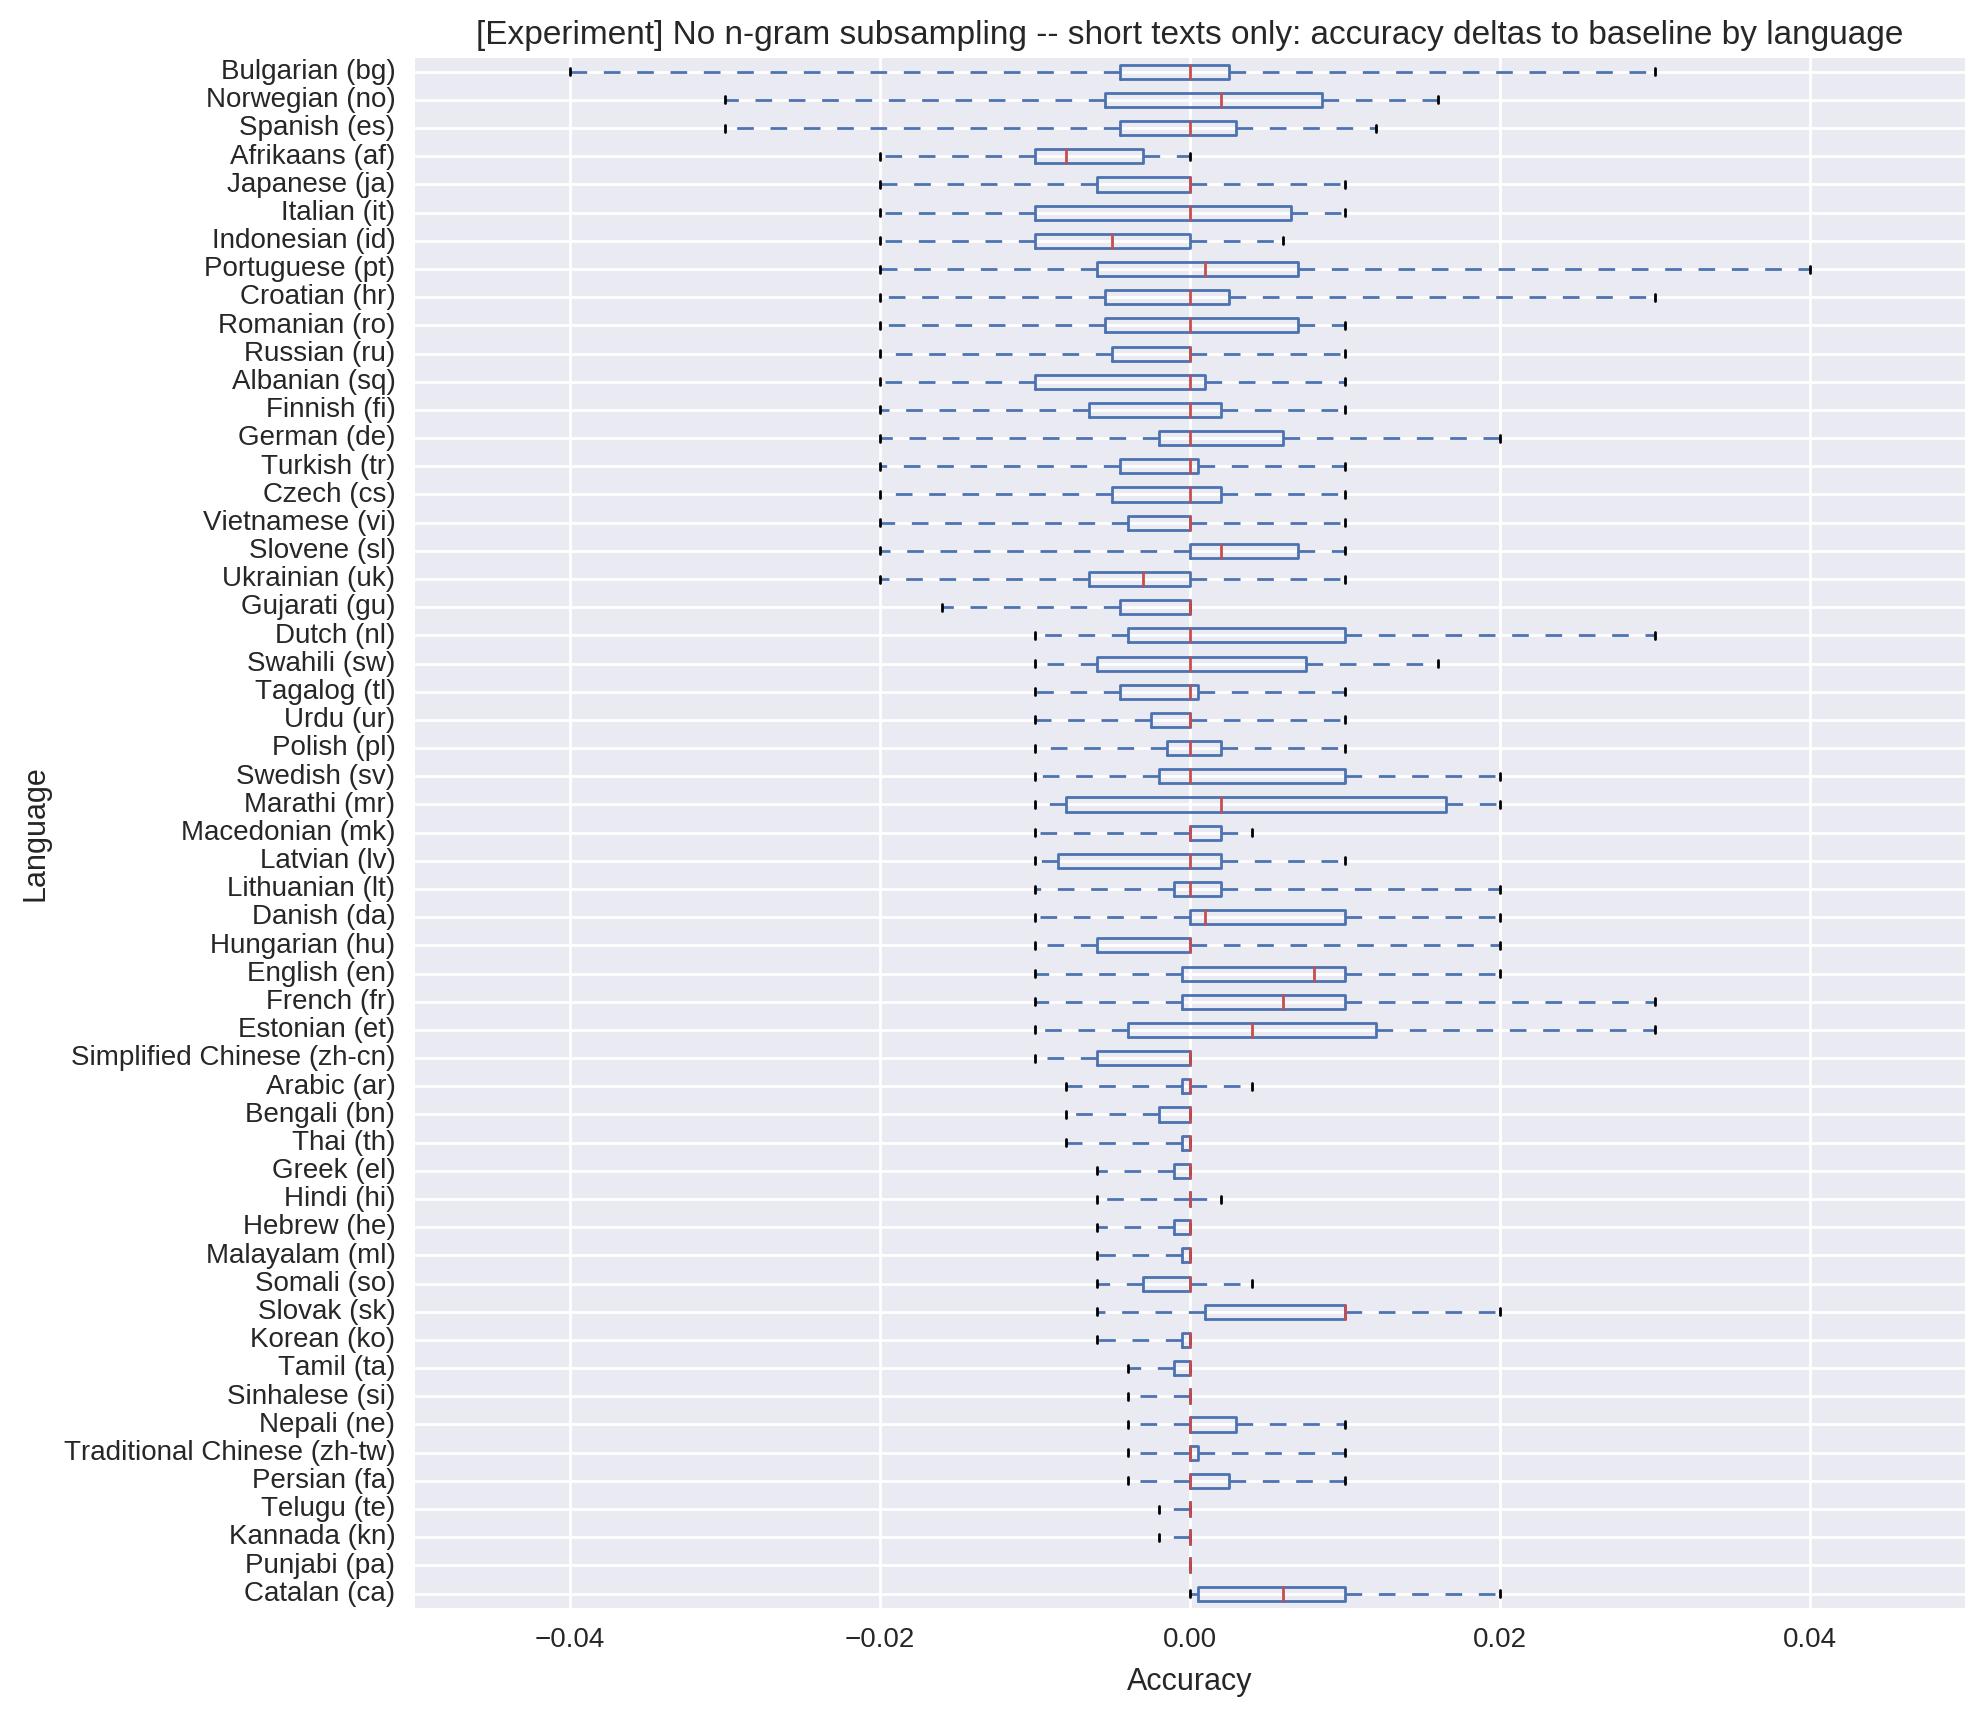

In [8]:
# Setting the default min_length to 1 because min_length=0 includes the full texts.
def filter_results_by_substring_length(results, min_length=1, max_length=20):
    return results[(min_length <= results['substringLength']) & (results['substringLength'] <= max_length)]

plot_accuracy_deltas_by_language(filter_results_by_substring_length(baseline_results),
                                 filter_results_by_substring_length(no_ngram_subsampling_results),
                                 '[Experiment] No n-gram subsampling -- short texts only:')